In [14]:
import torch
from transformers import *

To use data.metrics please install scikit-learn. See https://scikit-learn.org/stable/index.html


In [44]:
import numpy as np
import pandas as pd

STORY = "21st_year"

token_stimulus_df = pd.read_csv("data/{}/tr_tokens.csv".format(STORY)).fillna("")

In [45]:
token_stimulus_df.head()

,tr,Sentence,tr.1,index,tr_shift,prev_tr,story_section
0,0,This is Los Angeles.,0,A1.1,,,A1
1,1,And it's the height of summer.,1,A1.2,1,0,A1
2,2,In a small bungalow,2,A1.3,1,1,A1
3,3,"off of La Cienega,",3,A1.3,1,2,A1
4,4,Clara serves homemade chili,4,A1.3,1,3,A1


# RSMs from BERT

#### Set up BERT model

In [40]:
bert_weights = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights)

# Models can return full list of hidden-states & attentions weights at each layer
bert = BertModel.from_pretrained(bert_weights,
                                 output_hidden_states=True,
                                 output_attentions=True)

In [67]:
def stimulus_to_rsm_dataframe(stimulus, tr_lookback_window):

    # Set this inside the loop based on whichever BERT model we're using
    num_bert_layers = 0;

    tr_activation_array = {}
    for i, tr in enumerate(stimulus):

        # Get the whole window we're going to 
        window_start = max(0, i - tr_lookback_window)
        window_stimulus = " ".join(stimulus[window_start:i+1])
        window_tokens = torch.tensor([bert_tokenizer.encode(window_stimulus, add_special_tokens=True)])

        tr_tokens = torch.tensor([bert_tokenizer.encode(tr, add_special_tokens=False)])[0]

        with torch.no_grad():

            tr_activation_array[i] = {}
            bert_states, bert_attentions = bert(window_tokens)[-2:]
            num_bert_layers = len(bert_states)

            for l, layer in enumerate(bert_states):
                
                if len(tr_tokens) > 0:
                    # ASSUMPTION: we do not want to include the CLS/SEP token in the TR RSM.
                    # If we do, switch indexing here to include last token.
                    tr_activations = layer[0][-(len(tr_tokens) + 1):-1]
                    
                else:
                    # ASSUMPTION: if we don't have any tokens in this TR, use the last token's representation.
                    tr_activations = layer[0][-2:-1]

                # ASSUMPTION: take the mean of all tokens falling inside the TR stimuli window.
                tr_activation_array[i][l] = torch.mean(tr_activations, 0)

    # We now have the layers in a TR-based index: tr_activation_array[tr_index][layer_index]
    # To get a layer-wise RSM, we need to reverse this indexing. 
    layerwise_rsms = []
    for l in range(0, num_bert_layers):

        # Loop over our TR array and grab the target layer for each 
        layer_activations = [tr_activation_array[tr][l] for tr in tr_activation_array]
        stacked = np.stack([l.numpy() for l in layer_activations], axis=0)
        rsm_dataframe = pd.DataFrame(np.corrcoef(stacked))

        layerwise_rsms.append(rsm_dataframe)
    
    return layerwise_rsms

## Demo RSMs

Try generating a set of RSMs for a full text.

In [74]:
stimulus_for_rsm = token_stimulus_df

In [75]:
rsm_dfs = stimulus_to_rsm_dataframe(stimulus_for_rsm.Sentence.values, 20)

In [76]:
for i, df in enumerate(rsm_dfs):
    df.to_csv("data/{}/{}/layer_{}_rsm".format(STORY, bert_weights, i), header=False, index=False)

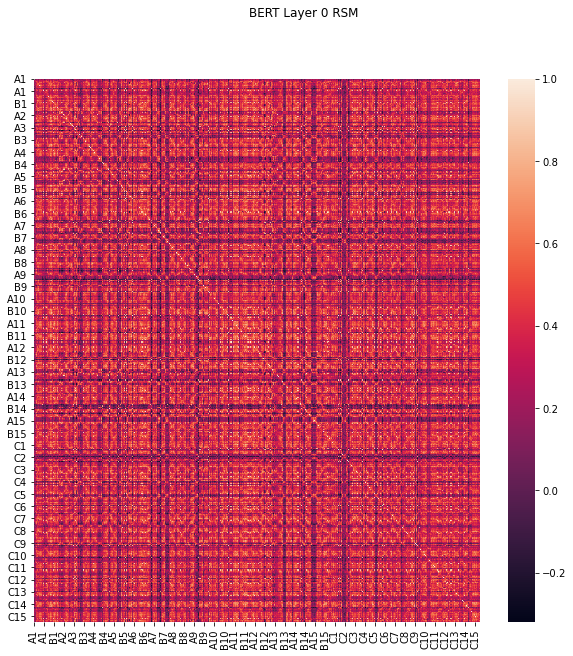

In [80]:
import matplotlib.pylab as plt
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.heatmap(rsm_dfs[0], xticklabels=stimulus_for_rsm.story_section.values, yticklabels=stimulus_for_rsm.story_section.values)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])
plt.suptitle("BERT Layer 0 RSM");

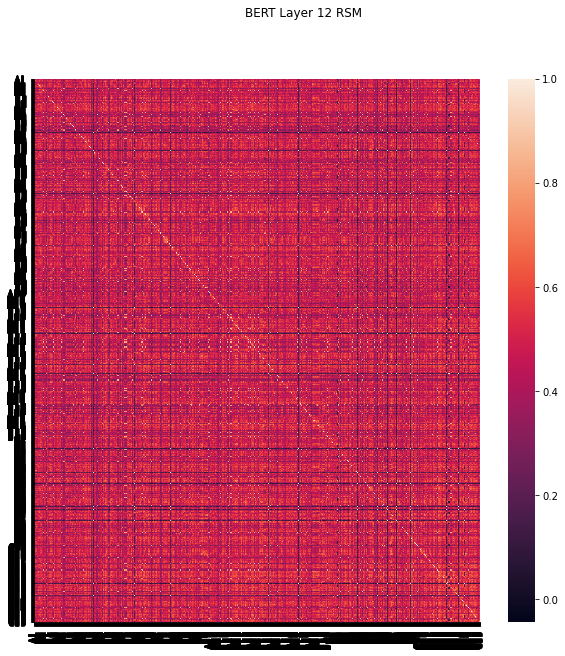

In [81]:
plt.figure(figsize=(10,10))
sns.heatmap(rsm_dfs[-1], xticklabels=stimulus_for_rsm.story_section.values, yticklabels=stimulus_for_rsm.story_section.values)

ax.set_xticks(ax.get_xticks()[::50])
ax.set_yticks(ax.get_yticks()[::50])

plt.suptitle("BERT Layer 12 RSM");

In [83]:
for i, df in enumerate(rsm_dfs):
    df.to_pickle("data/{}/{}/layer_{}_rsm.pkl".format(STORY, bert_weights, i))

In [85]:
foo = pd.read_pickle("data/{}/{}/layer_{}_rsm.pkl".format(STORY, bert_weights, 0))

In [88]:
np.triu(np.ones(foo.shape)).astype(np.bool)[0:5,0:5]

array([[ True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True]])